In [1]:
# setup_gpus() function for configuration the gpu on icolab jupyter hub implemented in separate file for reusability

# import gpu_init

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 2 Logical GPU
GPU Setup done


Hand-In of Group 13, Jonathan Ehrengruber (jonathan.ehrengruber@students.fhnw.ch), Christian Renold (christian.renold@hslu.ch)

# CNN - CIFAR10 - Data Augmentation

In [2]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('\033[91m' + 'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('\033[92m' + 'OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


## Loading the packages

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix

%matplotlib inline

Define a function to plot some images from CIFAR and load the dataset.

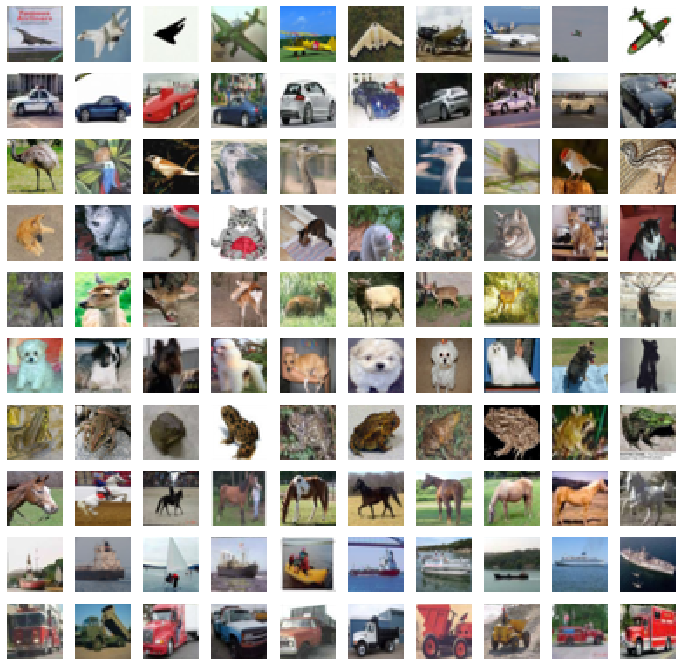

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [4]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

### Preprocessing data
After loading and splitting the data, we need to preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the \[0, 1\] interval.

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [6]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Define the network
The neural network will be a CNN. Follow the structure given in the exercise 1.

In [7]:
cnn = Sequential([
    Conv2D(32, kernel_size=(3,3), input_shape=(32,32,3,), activation='relu', padding='same'),
    Conv2D(32, kernel_size=(3,3), input_shape=(32,32,3,), activation='relu', padding='same'),
    MaxPooling2D((2,2)),    
    Conv2D(32, kernel_size=(3,3), input_shape=(32,32,3,), activation='relu', padding='same'),
    MaxPooling2D((2,2)), 
    Flatten(),
    Dense(units=10, activation='softmax')
])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                2

## Compile and train the network

When compiling the model, we need to specify the loss function, the optimizer and the metrics we want to track during the training. In Keras, we need to call the methods `compile()` and `fit()`. We will train through E epochs, using batches of size B, as specified in the exercise 1.

- The `categorical_crossentropy` loss is relevant for multiclass, single-label classification problem. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used `binary_crossentropy`.
- The `adam` optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

In [8]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=128)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 192us/sample - loss: 1.5664 - accuracy: 0.4403 - val_loss: 1.3431 - val_accuracy: 0.5163
Epoch 2/10
50000/50000 [==============================] - 7s 137us/sample - loss: 1.2147 - accuracy: 0.5719 - val_loss: 1.1361 - val_accuracy: 0.6016
Epoch 3/10
50000/50000 [==============================] - 7s 135us/sample - loss: 1.0675 - accuracy: 0.6290 - val_loss: 1.0751 - val_accuracy: 0.6278
Epoch 4/10
50000/50000 [==============================] - 7s 134us/sample - loss: 0.9702 - accuracy: 0.6645 - val_loss: 0.9670 - val_accuracy: 0.6633
Epoch 5/10
50000/50000 [==============================] - 7s 134us/sample - loss: 0.8994 - accuracy: 0.6907 - val_loss: 0.9186 - val_accuracy: 0.6816
Epoch 6/10
50000/50000 [==============================] - 7s 134us/sample - loss: 0.8492 - accuracy: 0.7086 - val_loss: 0.9265 - val_accuracy: 0.6784
Epoch 7/10
50000/50000 [=========================

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss and accuracy evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

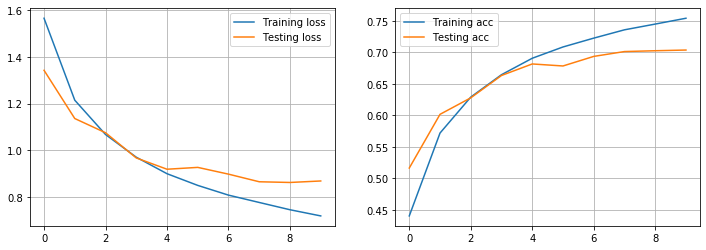

In [9]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [10]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.8681938652038574
Test accuracy: 0.7037


### Confusion matrix
We can call the `predict_classes()` function to get the predicted classes. The output of this function is an array with the predicted class labels as in `[5 0 4 1 ...]`. The output array of ground truth `y_test` and the predicted classes can then be fed to the `confusion_matrix()` function of [sklearn metrics package](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

In [11]:
pred = cnn.predict_classes(X_test, verbose=0)
confusion_matrix(y_test, pred)

array([[760,  26,  27,  15,  35,   1,   8,  15,  68,  45],
       [ 14, 825,   5,   4,   6,   2,   3,   7,  16, 118],
       [ 91,   8, 512,  59, 161,  34,  44,  66,  12,  13],
       [ 29,  22,  50, 516, 156,  65,  55,  62,  20,  25],
       [ 17,   6,  38,  39, 783,  10,  26,  66,  10,   5],
       [ 22,   7,  47, 222, 107, 451,  21,  96,  13,  14],
       [  5,   9,  45,  65, 114,   3, 729,  11,   8,  11],
       [  9,  12,  16,  21,  93,  20,   5, 807,   4,  13],
       [ 63,  39,  11,  10,  10,   3,   1,   7, 830,  26],
       [ 27,  64,   4,   9,  19,   1,   4,  24,  24, 824]])

## Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by heart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [118]:
train_size = len(X_train)
test_size = len(X_test)
batch_size = 128
epochs = 30

In [119]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=4, width_shift_range=0.04, shear_range=0.3, height_shift_range=0.04, zoom_range=0.04)

batches = gen.flow(X_train, Y_train, batch_size=256)
val_batches = gen.flow(X_test, Y_test, batch_size=256)

cnn1 = Sequential([
    Conv2D(32, kernel_size=(3,3), input_shape=(32,32,3,), activation='relu', padding='same'),
    Conv2D(32, kernel_size=(3,3), input_shape=(32,32,3,), padding='same'),
    Activation('relu'),
    MaxPooling2D((2,2)),    
    Conv2D(32, kernel_size=(3,3), input_shape=(32,32,3,), activation='relu', padding='same'),
    MaxPooling2D((2,2)), 
    Flatten(),
    Dense(units=10, activation='softmax')
])
cnn1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)             

Don't forget to reset your network (by defining it again). You need then to compile the network and train it. The call to the `fit()` function has to be replaced by a call to `fit_generator()` and using the data flow defined above. 

In [120]:
cnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = cnn1.fit_generator(batches, steps_per_epoch=train_size//batch_size, epochs=epochs, validation_data=val_batches, validation_steps=test_size//batch_size, use_multiprocessing=True)

Epoch 1/30
390/390 [==============================] - 62s 159ms/step - loss: 1.5531 - accuracy: 0.4473 - val_loss: 1.2876 - val_accuracy: 0.5476
Epoch 2/30
390/390 [==============================] - 62s 159ms/step - loss: 1.2119 - accuracy: 0.5728 - val_loss: 1.1311 - val_accuracy: 0.6007
Epoch 3/30
390/390 [==============================] - 62s 159ms/step - loss: 1.0678 - accuracy: 0.6268 - val_loss: 1.0402 - val_accuracy: 0.6350
Epoch 4/30
390/390 [==============================] - 62s 158ms/step - loss: 0.9752 - accuracy: 0.6598 - val_loss: 0.9992 - val_accuracy: 0.6519
Epoch 5/30
390/390 [==============================] - 61s 157ms/step - loss: 0.9141 - accuracy: 0.6808 - val_loss: 0.9420 - val_accuracy: 0.6700
Epoch 6/30
390/390 [==============================] - 62s 158ms/step - loss: 0.8784 - accuracy: 0.6930 - val_loss: 0.9126 - val_accuracy: 0.6849
Epoch 7/30
390/390 [==============================] - 60s 155ms/step - loss: 0.8440 - accuracy: 0.7049 - val_loss: 0.8955 - val_ac

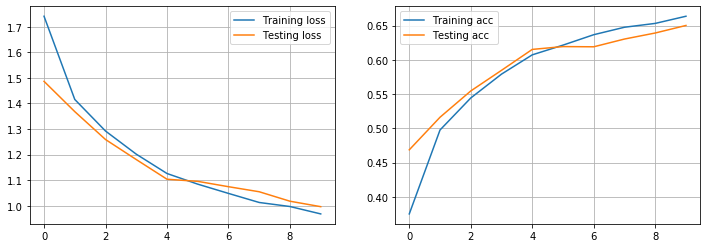

In [21]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [22]:
loss_test, metric_test = cnn1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.9184529335021973
Test accuracy: 0.691


### Table of results

| CNN | Batch Size | Epochs | Architecture description | Acc. train | Acc. test |
|-----|------------|--------|--------------------------|------------|-----------|
|  No DA | 128 | 10 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.7542  | 0.7037 |
|  With DA v1 | 128 | 10 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.7101  | 0.6906 |
|  With DA v1 | 256 | 10 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.6636  | 0.6501 |
|  With DA v1 | 128 | 30 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.7717  | 0.7326 |
|  With DA v1 | 256 | 30 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.7366  | 0.7104 |
|  With DA v2 | 128 | 30 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE |  0.7094 | 0.6957 |
|  With DA v2 | 256 | 30 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE |  0.6742 | 0.6591 |
|  With DA v3 | 128 | 30 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE |  0.7999 | 0.7436 |
|  With DA v3 | 256 | 30 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE |  0.7679 | 0.7209 |


| DA Version | Configuration |
|------------|:---------------|
| DA v1      | rotation_range=**8** , width_shift_range=**0.08**, shear_range=**0.3** , height_shift_range=**0.08**, zoom_range=**0.08** |
| DA v2      | rotation_range=**16**, width_shift_range=**0.16**, shear_range=**0.15**, height_shift_range=**0.16**, zoom_range=**0.16** |
| DA v3      | rotation_range=**4**,  width_shift_range=**0.04**, shear_range=**0.3**,  height_shift_range=**0.04**, zoom_range=**0.04** |

### Observations:

* Batch Size **128** performs in all the tests better than **256**.
* Data Augmentation appears to perform better, when smaller values in each configuration settings was used.
* Accuracy can still be improved with more epochs



## Activation Maps

Using the best of your network previously trained on CIFAR10 in exercise 1, implement a visualizer for the activations at different layer outputs.

Visualise the different activations maps of your network : outputs of CONV, RELU, MAXP. Comment on what you see.


In [146]:
from tensorflow.keras import models
import math

def visualize_filters_of_layer(layer_index, trained_model, visualize_image):
    layer_output = trained_model.layers[layer_index].output
    activation_model = models.Model(inputs=trained_model.input, outputs=layer_output)    
    visualize_image = visualize_image.reshape(1,32,32,3)    
    activations = activation_model.predict(visualize_image)
    
    filter_count = activations.shape[3]    
    plot_row_count = math.ceil(filter_count / 5)
    fig, axes = plt.subplots(nrows=plot_row_count, ncols=5, constrained_layout=True)
    fig.set_figheight(3*plot_row_count+3)
    fig.set_figwidth(15)
    fig.suptitle('Filters of Layer {0}'.format(layer_index), fontsize=20)
    for filter_idx in range(filter_count):
        row = filter_idx // 5
        col = filter_idx % 5
        axes[row, col].set_title("Filter {0}".format(filter_idx))
        axes[row, col].matshow(activations[0, :, :, filter_idx], cmap='Greys')
        axes[row, col].axis('off')


In [123]:
cnn1.layers

### Visualization of CONV Layer
we use the second conv layer (which doesn't include the relu activation)

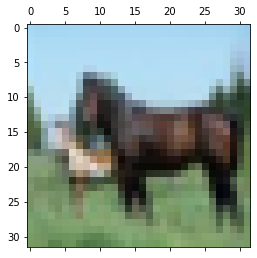

In [148]:
plt.matshow(X_train[12])

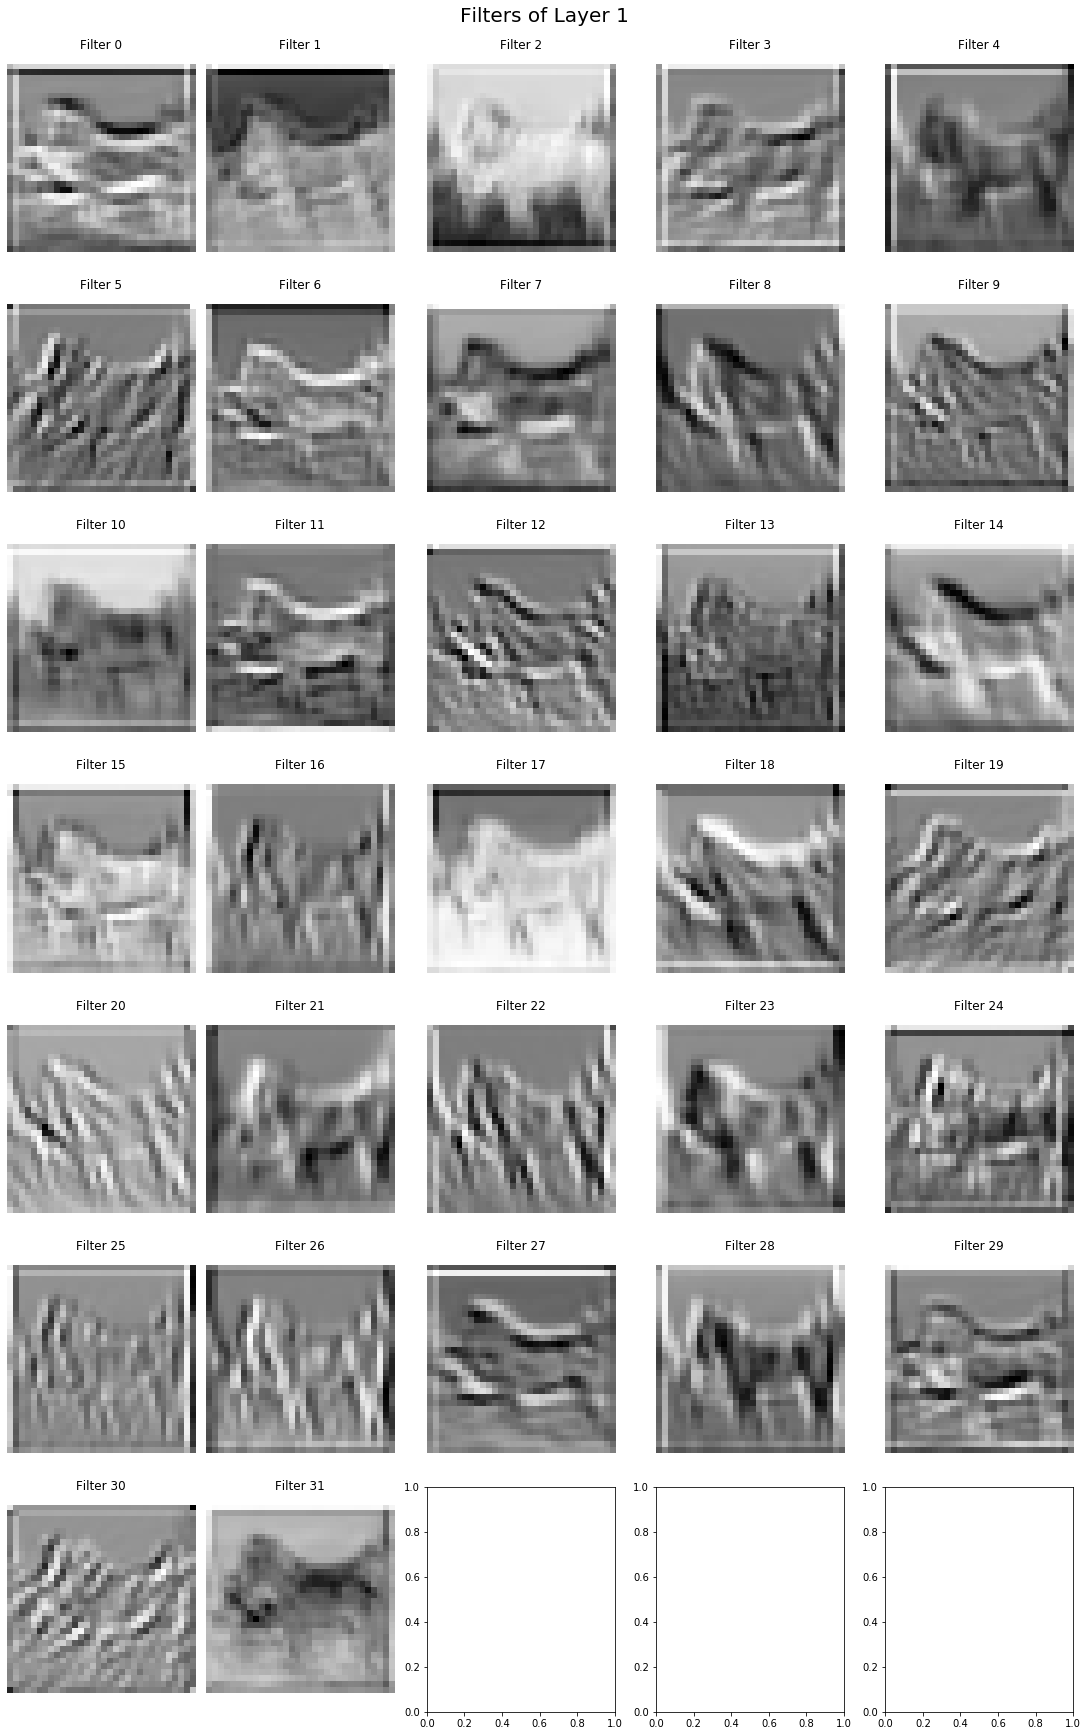

In [147]:
visualize_filters_of_layer(1, cnn1, X_train[12])

### Visualization of RELU Layer

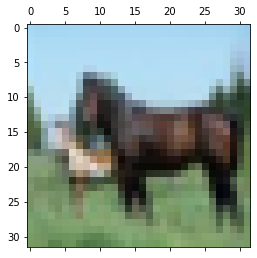

In [145]:
plt.matshow(X_train[12])

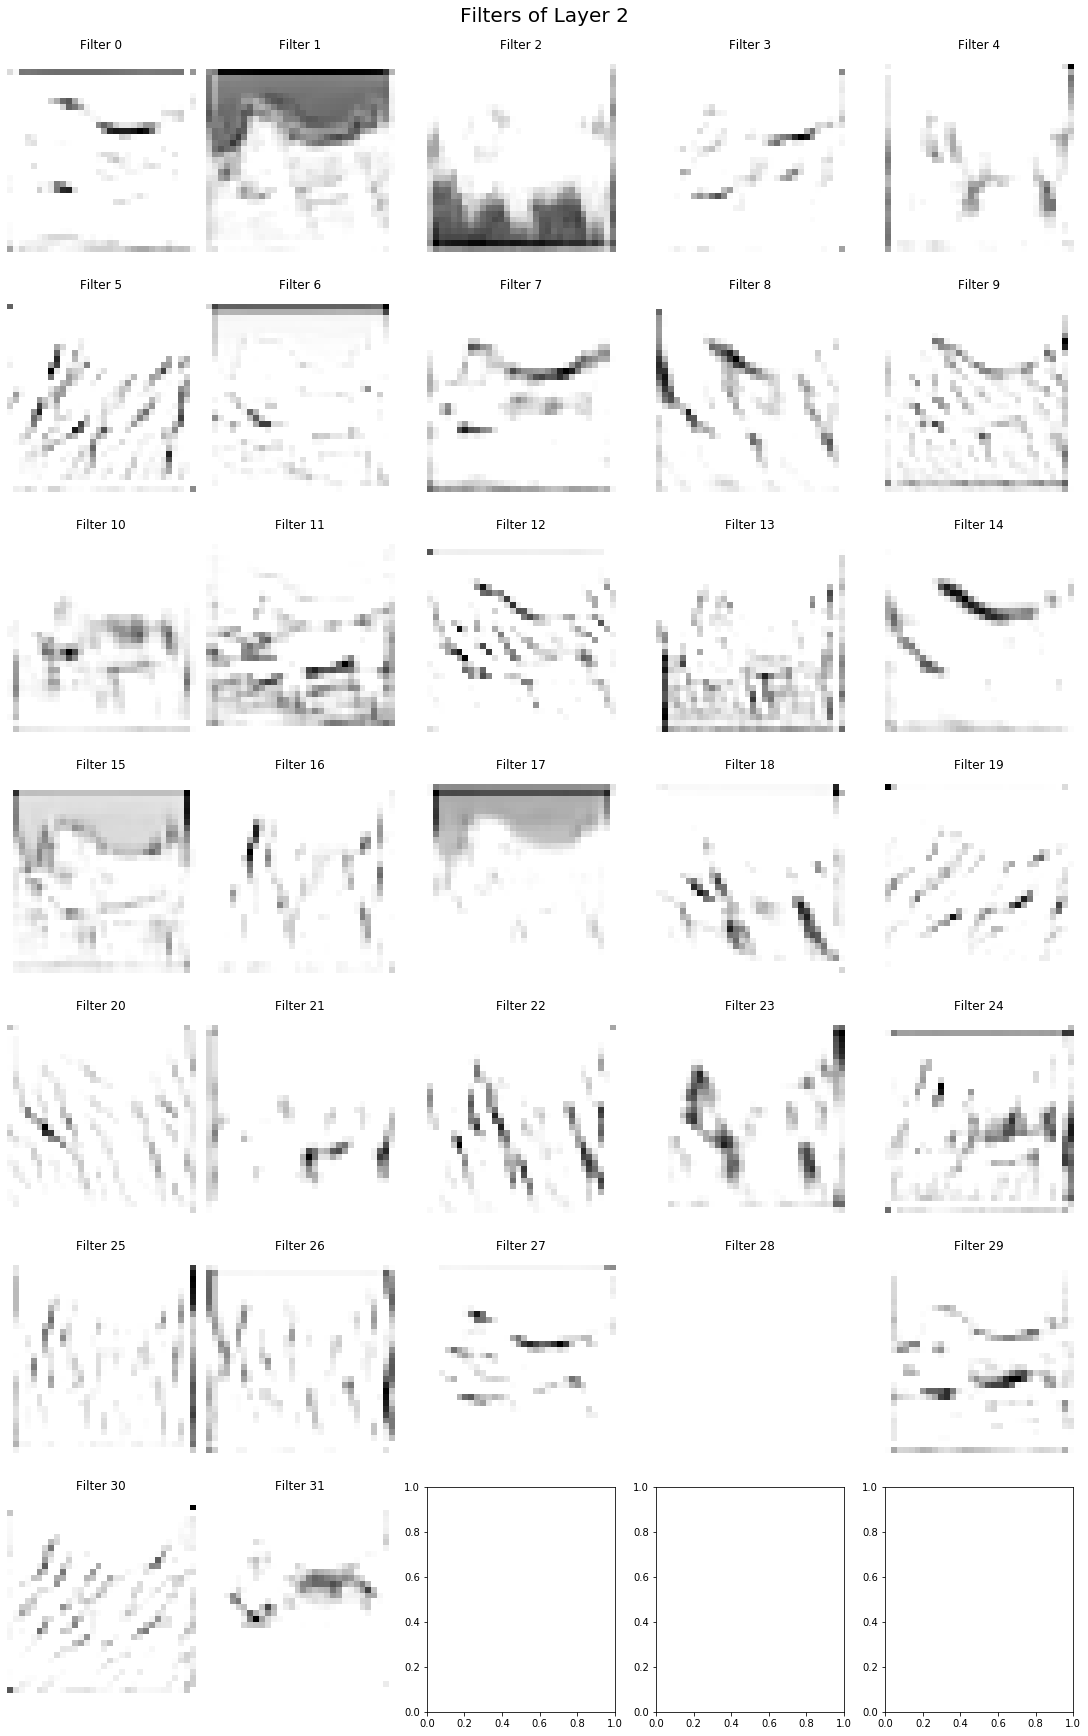

In [149]:
visualize_filters_of_layer(2, cnn1, X_train[12])

### Visualization of MAXPooling Layer
Layer 3 Max Pooling Outputs are 16x16 Images

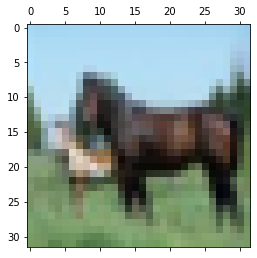

In [144]:
plt.matshow(X_train[12])

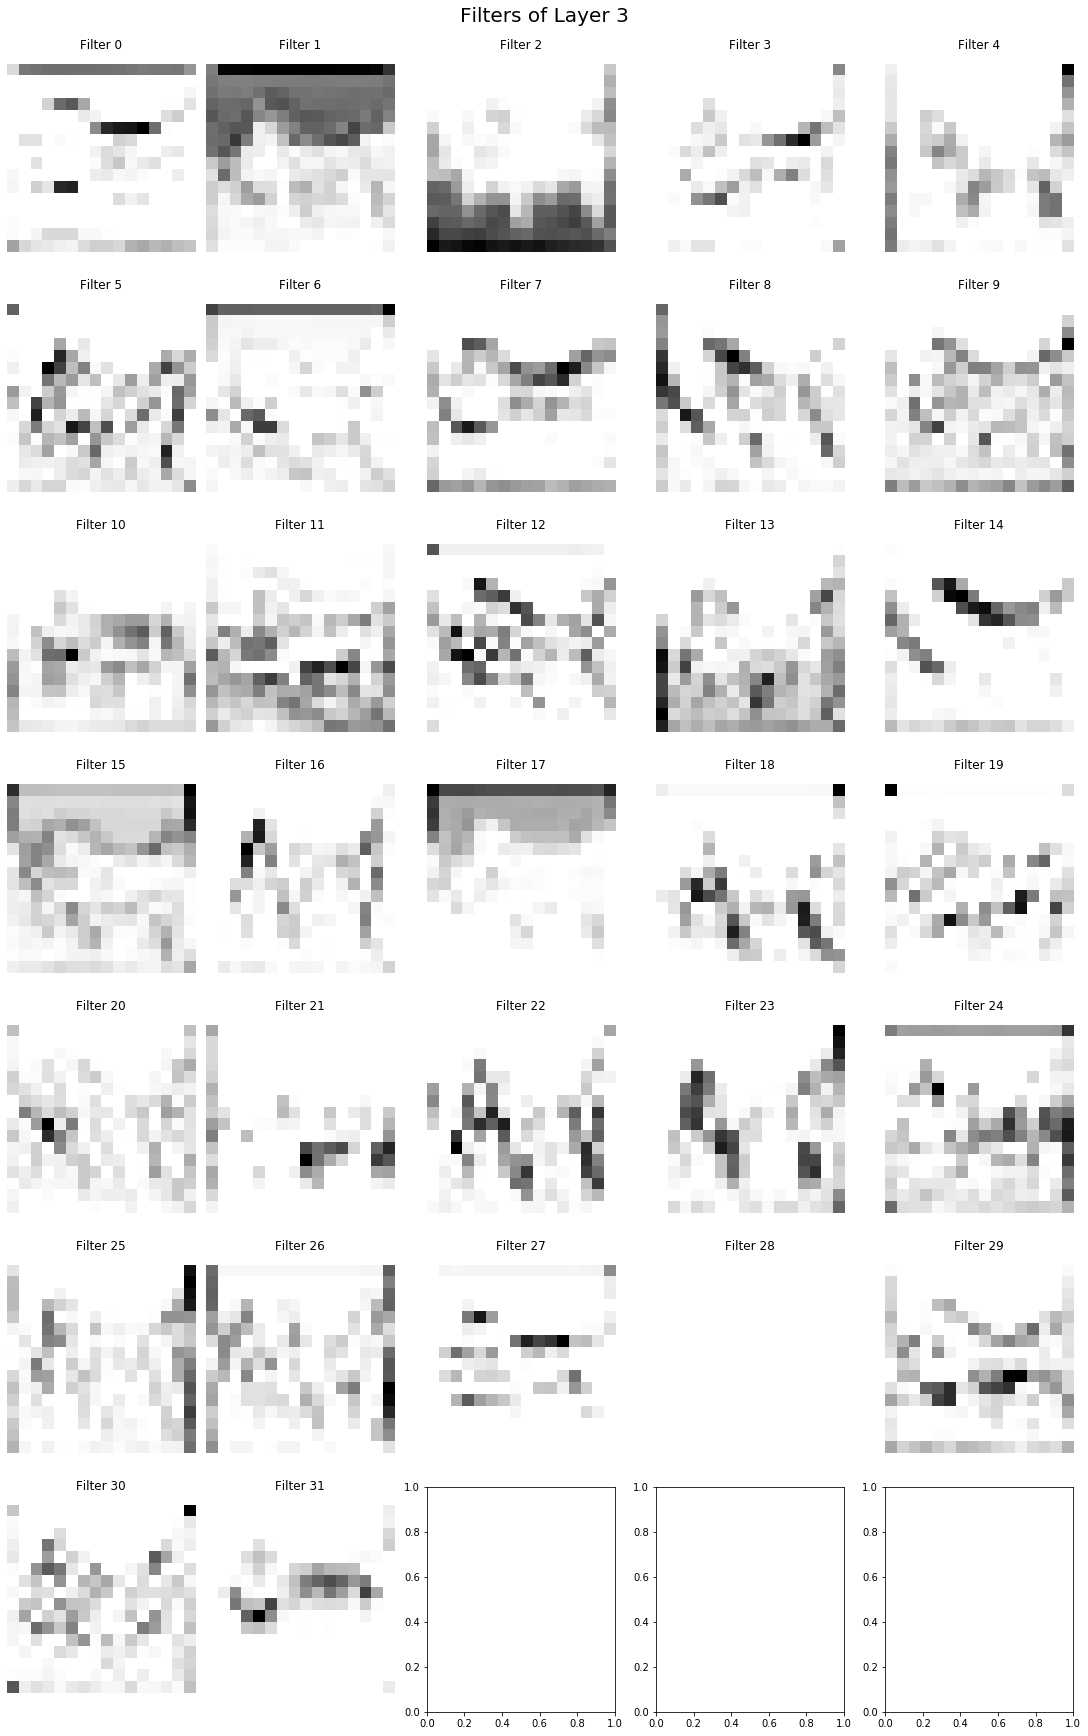

In [150]:
visualize_filters_of_layer(3, cnn1, X_train[12])

### Visualization of RELU Layer
Layer 5 Max Pooling Outputs are 8x8 Images

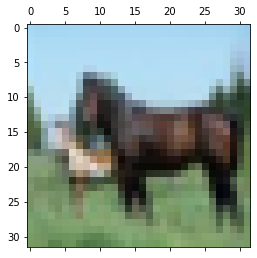

In [143]:
plt.matshow(X_train[12])

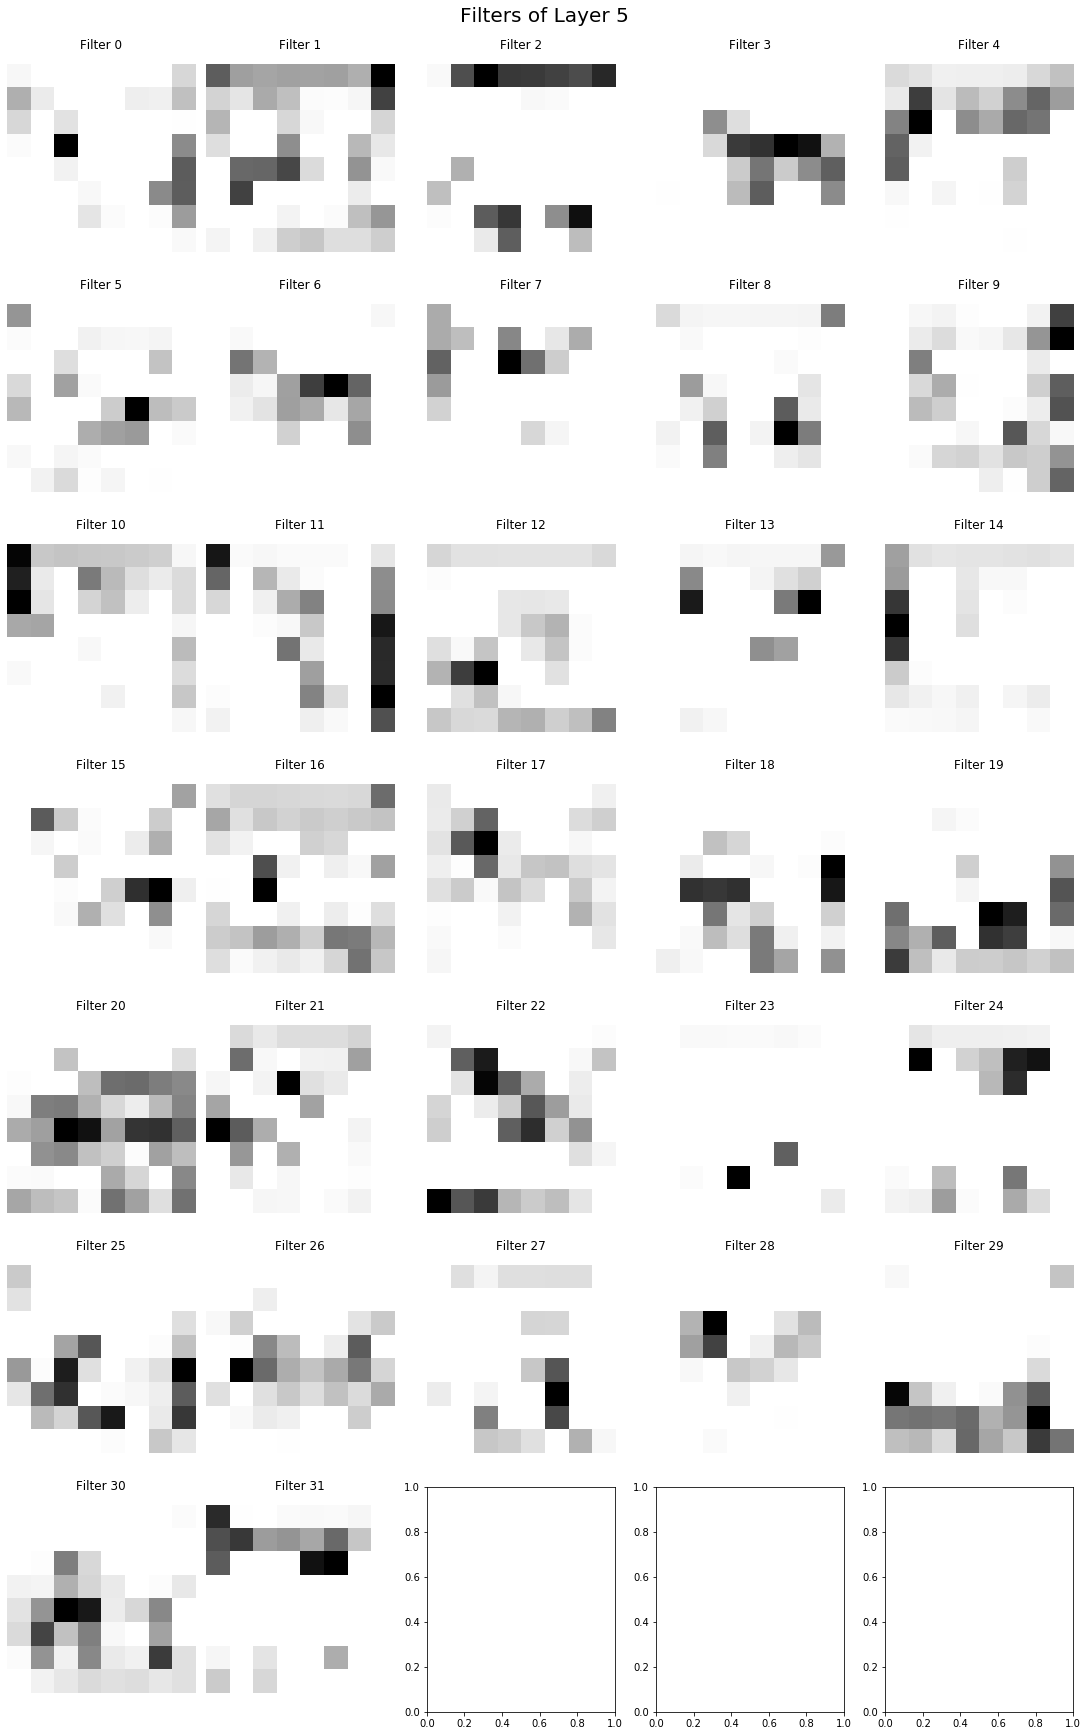

In [151]:
visualize_filters_of_layer(5, cnn1, X_train[12])